# Gaussian Naive Bayes - Lab

## Introduction

Now that you've seen how to employ multinomial Bayes for classification, its time to practice implementing the process yourself. Afterwards, you'll get a chance to further investigate the impacts of using true probabilities under the probability density function as opposed to the point estimate on the curve itself.

## Objectives

You will be able to:

* Independently code and implement the Gaussian Naive Bayes algorithm

## Load the Dataset

To start, load the dataset stored in the file 'heart.csv'. The dataset contains various measurements regarding patients and a 'target' feature indicating whether or not they have heart disease. You'll be building a GNB classifier to help determine whether future patients do or do not have heart disease. As reference, this dataset was taken from Kaggle. You can see the original data post here: https://www.kaggle.com/ronitf/heart-disease-uci.

In [1]:
#Your code here; load the dataset
import pandas as pd
import numpy as np

heart_df = pd.read_csv('./heart.csv')

In [2]:
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## Define the Problem

As discussed, the dataset contains various patient measurements along with a 'target' variable indicating whether or not the individual has heart disease. Define X and y below.

In [4]:
#Your code here
X = heart_df.drop('target', axis=1)
y = heart_df['target']

In [5]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [6]:
y.value_counts()

1    165
0    138
Name: target, dtype: int64

In [7]:
features = list(X.columns)
features

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

## Perform a Train-Test Split

While not demonstrated in the previous lesson, you've seen from your work with regression that an appropriate methodology to determine how well your algorithm will generalize to new data is to perform a train test split. 

> Note: Use random state 22 to have your results match those of the solution branch provided.

In [8]:
#Your code here; perform a train-test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(heart_df, random_state=22)

## Calculate the Mean & Standard Deviation of Each Feature for Each Class In the Train Set

Now, calculate the mean and standard deviation for each feature within each of the target class groups. This will serve as your a priori distribution estimate to determine the posterior likelihood of an observation belonging to one class versus the other.

In [9]:
#Your code here; calculate the mean and standard deviation for each feature within each class for the training set
train_stats = train_df.groupby('target').agg(['mean', 'std'])
train_stats.transpose()

target                  0           1
age      mean   57.281553   52.322581
         std     8.009085    9.995567
sex      mean    0.796117    0.564516
         std     0.404853    0.497832
cp       mean    0.466019    1.427419
         std     0.916253    0.972578
trestbps mean  134.067961  129.137097
         std    18.919469   16.589415
chol     mean  251.543689  240.516129
         std    52.341596   46.683240
fbs      mean    0.155340    0.112903
         std     0.364000    0.317758
restecg  mean    0.456311    0.629032
         std     0.538274    0.501506
thalach  mean  138.194175  158.185484
         std    22.359390   19.859411
exang    mean    0.543689    0.161290
         std     0.500523    0.369291
oldpeak  mean    1.600971    0.592742
         std     1.310253    0.749544
slope    mean    1.184466    1.580645
         std     0.555676    0.612827
ca       mean    1.213592    0.354839
         std     1.025656    0.818422
thal     mean    2.582524    2.072581
         std     0.602678    0.444906

## Define a Function to Calculate the Point Estimate for the Conditional Probability of a Feature Value for a Given Class

Recall that the point estimate is given by the probability density function of the normal distribution:  

 $$ \large P(x_i|y) = \frac{1}{\sqrt{2 \pi \sigma_i^2}}e^{\frac{-(x-\mu_i)^2}{2\sigma_i^2}}$$

> Note: Feel free to use the built in function from SciPy to do this as demonstrated in the lesson. Alternatively, take the time to code the above formula from scratch.

In [10]:
#Your code here
from scipy import stats

def p_x_given_class(feature, feature_obs, cls):
    
    mu = train_stats[feature]['mean'][cls]
    std = train_stats[feature]['std'][cls]

    #obs = df.iloc[row_indx][feature] #observation
    
    p_x_given_y = stats.norm.pdf(feature_obs, loc=mu, scale=std)
    
    return p_x_given_y

In [11]:
f_obs = train_df.loc[110]['sex']
p_x_given_class('sex', f_obs, 1)

0.4213184306017767

## Define a Prediction Function 

Define a prediction function that will return a predicted class value for a particular observation. To do this, calculate the point estimates for each of the features using your function above. Then, take the product of these point estimates for a given class and multiply it by the probability of that particular class. Take the class associated with the largest probability output from these calculations as your prediction.

In [12]:
##Your code here
def predict_class(df, features, label, row_obs):
    
    c_probs = []
    for c in range(2):
        p = sum(df[label]==c)/df.shape[0] #Initialize probability to relative probability of class
        for feature in features:
            p *= p_x_given_class(feature, row_obs[feature], c)
        c_probs.append(p)
        
    return np.argmax(c_probs)

In [13]:
r_obs = train_df.loc[230]
predict_class(train_df, features, 'target', r_obs)

1

## Apply Your Prediction Function to the Train and Test Sets

In [14]:
#Your code here
train_preds = np.array([predict_class(train_df, features, 'target', train_df.loc[row]) for row in train_df.index])
test_preds = np.array([predict_class(train_df, features, 'target', test_df.loc[row]) for row in test_df.index])

## Calculate the Train and Test Accuracy

In [15]:
#Your code here
train_acc = sum((train_df['target']==train_preds))/train_df.shape[0]
test_acc = sum((test_df['target']==test_preds))/test_df.shape[0]
train_acc, test_acc

(0.8502202643171806, 0.8289473684210527)

## Level-Up

### Adapting Point Estimates for the Conditional Probability Into True Probability Estimates

As discussed, the point estimate from the probability density function is not a true probability measurement. Recall that the area under a probability density function is 1, representing the total probability of all possible outcomes. Accordingly, to determine the probability of a feature measurement occurring, you would need to find the area under some portion of the PDF. Determining appropriate bounds for this area however is a bit tricky and arbitrary. For example, when generating a class prediction, you would want to know the probability of a patient having a resting blood pressure of 145 given that they had heart disease versus the probability of having a resting blood pressure of 145 given that the did not have heart disease. Previously, you've simply used the point where x=145 on the PDF curve to do this. However, the probability of any single point is actually 0. To calculate an actual probability, you would have to create a range around the observed value such as "what is the probability of having a resting blood pressure between 144 and 146 inclusive?" Alternatively, you could narrow the range and rewrite the problem as "what is the probability of having a resting blood pressure between 144.5 and 145.5?" Since defining these bounds is arbitrary, a potentially interesting research question is how various band methods might impact output predictions and the overall accuracy of the algorithm.


## Rewriting the Conditional Probability Formula

Rewrite your conditional probability formula above to take a feature observation, a given class and a range width and calculate the actual probability beneath the PDF curve of an observation falling within the range of the given width centered at the given observation value. For example, taking up the previous example of resting blood pressure, you might calculate the probability of having a resting blood pressure within 1bp of 145 given that a patient has heart disease. In this case, the range width would be 2bp (144bp to 146bp) and the corresponding area under the PDF curve for the normal distribution would look like this:  

<img src="images/pdf_integral.png">

With that, write such a function below.

In [16]:
def p_band_x_given_class(obs_row, feature, c, range_width_std):
    """obs_row is the observation in question.
    feature is the feature of the observation row for which you are calculating a conditional probability for.
    C is the class flag for the conditional probability.
    Range width is the range in standard deviations of the feature variable to calculate the 
    integral under the PDF curve for"""
    #Your code here
    mu = agg_stats[feature]['mean'][cls]
    std = agg_stats[feature]['std'][cls]

    f_obs = obs_row[row_indx][feature] #observation
    
    p_x_given_y = stats.norm.pdf(f_obs, loc=[mu-range_width_std, mu+range_width_std], scale=std)
    
    return p_x_given_y

## Update the Prediction Function

Now, update the prediction function to use this new conditional probability function. Be sure that you can pass in through the range width variable to this wrapper function.

In [17]:
#Your code here; update the prediction function

## Experiment with the Impact of Various Range-Widths

Finally, create a for loop to measure the impact of varying range-widths on the classifier's test and train accuracy. Iterate over various range-widths from .1 standard deviations to 2 standard deviations. For each of these, store the associated test and train accuracies. Finally, plot these on a graph. The x-axis should be the associated range-width (expressed in standard deviations; each feature will have a unique width applicable to the specific scale). The y-axis will be the associated accuracy. Be sure to include a legend for train accuracy versus test accuracy.

In [18]:
#Your code here

> Comment: Not a wild difference from our point estimates obtained by using points from the PDF itself, but there is some impact. Interestingly, these graphs will differ substantially in shape depending on the initial train test split used. The recommendation would be to use the point estimates from the PDF itself, or a modest band-width size.

## Additional Appendix: Plotting PDFs and Probability Integrals

Below, feel free to take a look at the code used to generate the PDF graph image above.

In [19]:
df = heart_df
temp = df[df.target==1]['trestbps']
aggs = temp.agg(['mean', 'std'])
aggs

mean    129.303030
std      16.169613
Name: trestbps, dtype: float64

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import scipy.stats as stats
sns.set_style('white')

Probability of Blood Pressure Falling withing Range for the Given Class: 0.03080251623846908


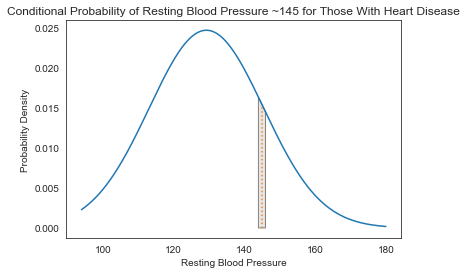

In [21]:
x = np.linspace(temp.min(), temp.max(), num=10**3)
pdf = stats.norm.pdf(x, loc=aggs['mean'], scale=aggs['std'])
xi = 145
width = 2
xi_lower = xi - width/2
xi_upper = xi + width/2

fig, ax = plt.subplots()

plt.plot(x, pdf)

# Make the shaded region
ix = np.linspace(xi_lower, xi_upper)
iy = stats.norm.pdf(ix, loc=aggs['mean'], scale=aggs['std'])
verts = [(xi_lower, 0), *zip(ix, iy), (xi_upper, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly);

plt.plot((145, 145), (0, stats.norm.pdf(145, loc=aggs['mean'], scale=aggs['std'])), linestyle='dotted')
p_area = stats.norm.cdf(xi_upper, loc=aggs['mean'], scale=aggs['std']) - stats.norm.cdf(xi_lower, loc=aggs['mean'], scale=aggs['std'])
print('Probability of Blood Pressure Falling withing Range for the Given Class: {}'.format(p_area))
plt.title('Conditional Probability of Resting Blood Pressure ~145 for Those With Heart Disease')
plt.ylabel('Probability Density')
plt.xlabel('Resting Blood Pressure');

> Comment: See https://matplotlib.org/gallery/showcase/integral.html for further details on plotting shaded integral areas under curves.

## Summary

Well done! In this lab, you implemented the Gaussian Naive Bayes classifier from scratch, used it to generate classification predictions and then validated the accuracy of the model. If you wish to go further, continue on below with some optional extension exercises.